In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import random
from tqdm import *


In [2]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)

#runner = runner.dropna()
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)
join = join.loc[~join.runner_id.isna()]

In [ ]:
join.info()

In [ ]:
join.loc[join.time_in_seconds.isna()]

In [ ]:
def multiple_runner_profile(join, race, race_year_id_list):
    #Collect data from course
    #Return df
    huge_df = pd.DataFrame()
    
    for race_year_id_to_predict in tqdm(race_year_id_list):
        df = pd.DataFrame()
        race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
        race_year_id = race_to_predict.iloc[0]['race_year_id']
        date_to_predict = race_to_predict.iloc[0]['date']
        distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
        country_to_predict = race_to_predict.iloc[0]['country_code']


        unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
        for runner in unique_runners:
            runner_info = join.loc[(join.runner_id == runner) & (join.race_year_id == race_year_id)]
            runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
            
            #runner_info['relative_ranking'] = runner_info['relative_ranking'].fillna(1)
            runner_past['relative_ranking'] = runner_past['relative_ranking'].fillna(1)
            runner_past['speed'] = runner_past['speed'].fillna(0)
            runner_past['equivalent_speed'] = runner_past['equivalent_speed'].fillna(0)
            

            # Data processing
            #General data
            rr_id =  ''.join([str(runner), str(race_to_predict.iloc[0].race_year_id)])
            runner_id = runner
            age = runner_info['age_course'].iloc[0]
            gender = runner_info['gender'].iloc[0]
            nationality = runner_info['nationality'].iloc[0]

            #Race information
            race_year_id = runner_info['race_year_id'].iloc[0]
            race_distance = runner_info['distance'].iloc[0]
            race_elevation_gain = runner_info['elevation_gain'].iloc[0]
            race_equivalent_distance = runner_info['equivalent_distance'].iloc[0]
            race_weighted_elevation = runner_info['weighted_elevation'].iloc[0]
            race_freq = runner_info['frequency_in_ranking'].iloc[0]


            #Processed data
            total_races = 0
            avg_relative_rank = 1
            max_relative_rank = 1
            min_relative_rank = 1

            total_elevation = 0
            avg_elevation = 0

            total_distance = 0
            avg_distance = 0
            min_distance = 0
            max_distance = 0

            total_eq_distance = 0
            avg_eq_distance = 0
            min_eq_distance = 0
            max_eq_distance = 0

            avg_runners = 0

            years_of_activity = 0
            last_year_activity = race_to_predict.year

            has_run = 0
            has_run_last_year = 0
            has_run_equivalent_course = 0
            avg_course_per_year = 0
            distance_previous_year = 0
            ranking_score = 0
            avg_speed = 0
            last_course_speed = 0
            home_country = 0
            avg_speed = 0
            avg_equivalent_speed = 0
            
            has_dropped_past = np.any(runner_past.ranking.isna())
            dropped = np.isnan(runner_info.iloc[0].time_in_seconds)
            
            




            if nationality == country_to_predict:
                home_country = 1

            if runner_past.size > 0:
                has_run = 1
                total_races = runner_past.shape[0]

                avg_relative_rank = runner_past.relative_ranking.mean()
                avg_rank = runner_past.ranking.mean()
                max_relative_rank = runner_past.relative_ranking.max()
                min_relative_rank = runner_past.relative_ranking.min()

                total_elevation = runner_past.elevation_gain.sum()
                avg_elevation = runner_past.elevation_gain.mean()

                total_distance =  runner_past.distance.sum()
                avg_distance = runner_past.distance.mean()
                min_distance = runner_past.distance.min()
                max_distance = runner_past.distance.max()

                total_eq_distance = runner_past.equivalent_distance.sum()
                avg_eq_distance = runner_past.equivalent_distance.mean()
                min_eq_distance = runner_past.equivalent_distance.min()
                max_eq_distance = runner_past.equivalent_distance.max()

                avg_runners = runner_past.frequency_in_ranking.mean()

                avg_speed = runner_past.equivalent_speed.mean()
                last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']

                years_of_activity = int(race_to_predict.year) - int(runner_past.year.min())

                last_year_activity = runner_past.year.max()


                avg_speed = runner_past.speed.mean()
                avg_equivalent_speed = runner_past.equivalent_speed.mean()


                for i in range(len(runner_past)):
                    if not np.isnan(runner_past.iloc[i,1]):
                        ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

                if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                    has_run_equivalent_course = 1

                year_interval = runner_past.year.max()- runner_past.year.min()
                if year_interval != 0:
                    avg_course_per_year = total_races / year_interval



            df = df.append({'rr_id' : rr_id,
                            'runner_id': runner_id,
                            'ranking': runner_info.iloc[0]['ranking'],
                            'relative_ranking': runner_info.iloc[0]['relative_ranking'],
                            'time_in_seconds': runner_info.iloc[0]['time_in_seconds'],
                            'age': age, 
                            'gender': gender, 
                            'nationality':nationality,
                            'n_races': total_races,
                            'ranking_score':ranking_score,
                            'avg_relative_rank': avg_relative_rank,
                            'max_relative_rank' : max_relative_rank,
                            'min_relative_rank' : min_relative_rank,
                            'total_elevation' : total_elevation,
                            'avg_elevation' : avg_elevation,
                            'total_distance' : total_distance,
                            'avg_distance' : avg_distance,
                            'min_distance' : min_distance,
                            'max_distance' : max_distance,
                            'total_eq_distance' : total_eq_distance,
                            'avg_eq_distance' : avg_eq_distance,
                            'min_eq_distance' : min_eq_distance,
                            'max_eq_distance' : max_eq_distance,
                            'avg_runners' : avg_runners,
                            'years_of_activity': years_of_activity,
                            'last_year_activity': last_year_activity,
                            'avg_speed': avg_speed,
                            'avg_equivalent_speed': avg_equivalent_speed,
                            'total_distance': total_distance,
                            'has_run': has_run,
                            'has_run_equivalent_course': has_run_equivalent_course,
                            'avg_course_per_year': avg_course_per_year,
                            'avg_speed': avg_speed,
                            'last_course_speed': last_course_speed,
                            'home_country': home_country,
                            'race_race_year_id' :race_year_id,
                            'race_distance' : race_distance,
                            'race_elevation_gain' : race_elevation_gain,
                            'race_equivalent_distance' : race_equivalent_distance,
                            'race_weighted_elevation' : race_weighted_elevation,
                            'race_freq' : race_freq,
                            'has_dropped_past': has_dropped_past,
                            'dropped': dropped
                           }, ignore_index = True)

        huge_df = huge_df.append(df, ignore_index=True)

                
    one_hot_gender = pd.get_dummies(huge_df['gender'], prefix = "gender")
    huge_df = huge_df.drop('gender',axis = 1)
    huge_df = huge_df.join(one_hot_gender)
    
    return huge_df

In [ ]:
df = multiple_runner_profile(join, race, race.loc[race.year >= 2018].race_year_id)

In [ ]:
msno.matrix(df)

In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_ACP = df.drop(columns=['rr_id','runner_id','ranking','relative_ranking','time_in_seconds','nationality'])

cls = PCA(n_components=5)
pcs = cls.fit_transform(StandardScaler().fit_transform(df_ACP))

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['dropped'] = df.dropped


sns.scatterplot(x = "axis1", y = "axis2", hue ="dropped", data = X, alpha = 0.3)
plt.savefig('test1.pdf')


In [ ]:
from pathlib import Path  

filepath = Path('../../output/data_clean/training_logit_data.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

df.to_csv(filepath)  

In [3]:
df = pd.read_csv('../../output/data_clean/training_logit_data.csv', index_col=0)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
import missingno as msno

In [5]:
df2 = df.drop(columns=['relative_ranking','ranking','time_in_seconds','ranking_score','last_year_activity'])

In [6]:
df2.nationality = pd.Categorical(
    df2.nationality, categories=df2.nationality.unique(),ordered=False
)


df2 = df2.assign(
    nationality_cat = df2.nationality.cat.codes,
)
df2 = df2.drop(columns=['nationality','race_race_year_id','runner_id'])

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59285 entries, 0 to 59284
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   rr_id                      59285 non-null  object 
 1   age                        59285 non-null  float64
 2   n_races                    59285 non-null  float64
 3   avg_relative_rank          59285 non-null  float64
 4   max_relative_rank          59285 non-null  float64
 5   min_relative_rank          59285 non-null  float64
 6   total_elevation            59285 non-null  float64
 7   avg_elevation              59285 non-null  float64
 8   total_distance             59285 non-null  float64
 9   avg_distance               59285 non-null  float64
 10  min_distance               59285 non-null  float64
 11  max_distance               59285 non-null  float64
 12  total_eq_distance          59285 non-null  float64
 13  avg_eq_distance            59285 non-null  flo

In [8]:
X = df2.drop(columns=['rr_id','dropped'])
y = df2['dropped']

<AxesSubplot:>

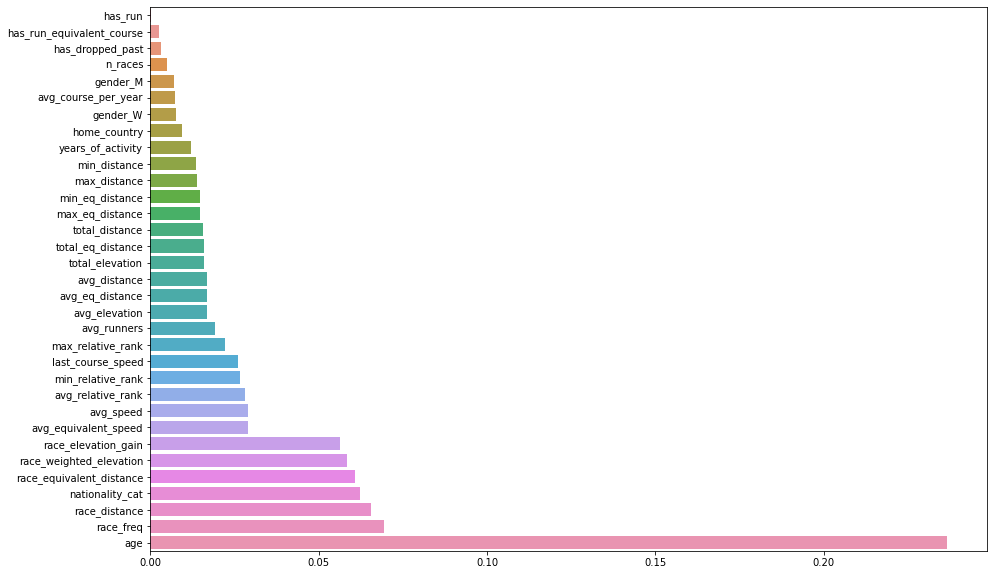

In [9]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier()
cls.fit(X, y)
importance = cls.feature_importances_
features = X.columns
df_importance = pd.DataFrame({'features':features,'importance':importance})
df_importance = df_importance.sort_values(by = ['importance'], ascending = False)
plt.figure(figsize=(15,10))
sns.barplot(x = importance, y = features, data = df_importance, order=df_importance.sort_values('importance').features)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
def incremental_logit(importance_df, X, y):
    X = StandardScaler().fit_transform(X)
    logreg=LogisticRegression(max_iter = 1000, n_jobs = 4)
    
    importance_df = importance_df.sort_values('importance', ascending=False)
    incr_logit_score = pd.DataFrame()
    
    for i in tqdm(range(len(importance_df))):
        predicted = cross_val_predict(logreg, X, y, cv=5)
        accuracy = metrics.accuracy_score(y, predicted)
        incr_logit_score = incr_logit_score.append({
                                'variable':i,
                                 'accuracy':accuracy
                                }, ignore_index=True)
        
    return incr_logit_score
    
res = incremental_logit(df_importance,X,y)

  0%|                                                    | 0/33 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [108]:
df3 = df2.loc[df2.dropped == False].sample(n = 13656)
df4 = df2.loc[df2.dropped == True]
df5 = pd.concat([df3,df4], axis=0, ignore_index=True)

In [110]:
X = df5.drop(columns=['rr_id','dropped'])
y = df5['dropped']

In [ ]:
X = df5.drop(columns=['rr_id','dropped'])
y = df5['dropped']
X = StandardScaler().fit_transform(X)

logreg=LogisticRegression(max_iter = 10000, n_jobs = 4)

predicted = cross_val_predict(logreg, X, y, cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

In [85]:
score = metrics.accuracy_score(y, predicted)

In [86]:
cm = metrics.confusion_matrix(y, predicted)

Text(0.5, 1.0, 'Accuracy Score: 0.3287172134604031')

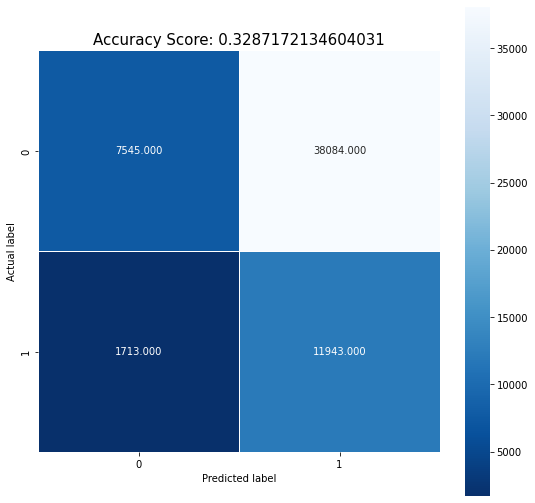

In [87]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)


#plt.savefig('logreg_confusion_matrix.pdf')

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

0.7694357763346547
              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87     45629
         1.0       0.49      0.03      0.06     13656

    accuracy                           0.77     59285
   macro avg       0.63      0.51      0.47     59285
weighted avg       0.71      0.77      0.68     59285



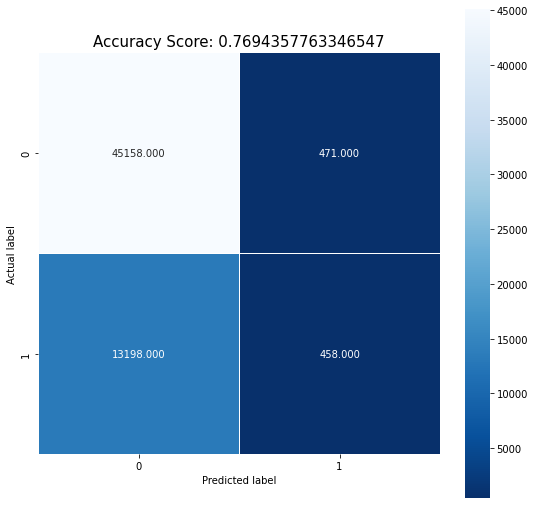

In [67]:
X = df5.drop(columns=['rr_id','dropped'])
y = df5['dropped']

X = StandardScaler().fit_transform(X)


logreg=LinearDiscriminantAnalysis()

predicted = cross_val_predict(logreg, X, y, cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))
score = metrics.accuracy_score(y, predicted)
cm = metrics.confusion_matrix(y, predicted)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

plt.savefig('LDA_confusion_matrix.pdf')

/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables ar

0.46679598549380114
              precision    recall  f1-score   support

         0.0       0.82      0.39      0.53     45629
         1.0       0.26      0.72      0.38     13656

    accuracy                           0.47     59285
   macro avg       0.54      0.56      0.46     59285
weighted avg       0.70      0.47      0.50     59285



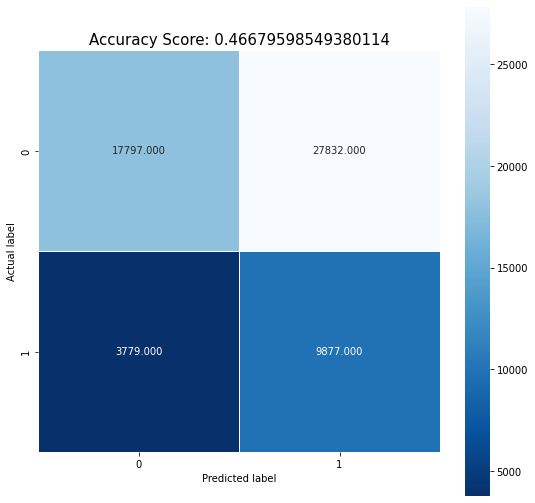

In [68]:
X = df5.drop(columns=['rr_id','dropped'])
y = df5['dropped']
X = StandardScaler().fit_transform(X)

logreg=QuadraticDiscriminantAnalysis()

predicted = cross_val_predict(logreg, X, y, cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))
score = metrics.accuracy_score(y, predicted)
cm = metrics.confusion_matrix(y, predicted)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

plt.savefig('QDA_confusion_matrix.pdf')

0.5030108796491524
              precision    recall  f1-score   support

         0.0       0.84      0.44      0.58     45629
         1.0       0.28      0.71      0.40     13656

    accuracy                           0.50     59285
   macro avg       0.56      0.58      0.49     59285
weighted avg       0.71      0.50      0.54     59285



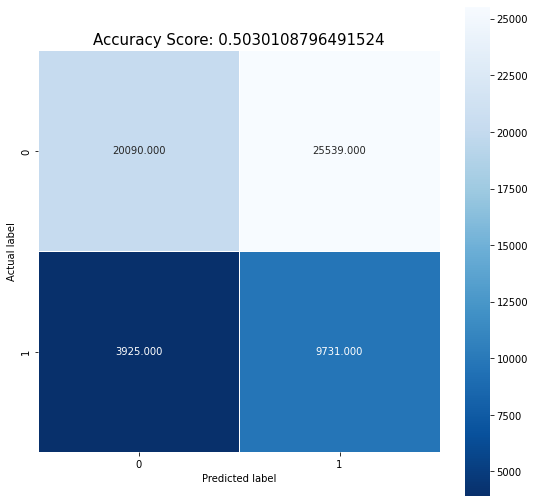

In [69]:
X = df5.drop(columns=['rr_id','dropped'])
y = df5['dropped']
X = StandardScaler().fit_transform(X)


logreg=GaussianNB()

predicted = cross_val_predict(logreg, X, y, cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))
score = metrics.accuracy_score(y, predicted)
cm = metrics.confusion_matrix(y, predicted)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

plt.savefig('GNB_confusion_matrix.pdf')

In [75]:
X = df2[['age','race_freq','race_distance','nationality_cat']]
y = df2['dropped']